In [1]:
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch import optim

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy

#### MNIST 데이터 불러오기

In [3]:
img_transform = transforms.Compose([ 
    #transforms.Resize(), 
     transforms.ToTensor(),  
     transforms.Normalize((0.5,),(0.5,))   
])

num_epochs = 100  
batch_size = 128 
# learning_rate 안씀  

In [4]:
train = MNIST(root = './mnist_data', train = True, transform = img_transform, download = True) #이 코드가 있는 곳에, mnist_data 폴더를 만들어서, 데이터를 저장하겠다 
test = MNIST(root = './mnist_data', train = False, transform = img_transform, download = True)  
dataloader1 = DataLoader(train, batch_size = batch_size, shuffle = True )  
dataloader2 = DataLoader(test, batch_size = 10000, shuffle = True ) 

In [5]:
print(train)  
print(test)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./mnist_data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None
Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./mnist_data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None


#### EDA mnist

In [6]:
print(type(train))

<class 'torchvision.datasets.mnist.MNIST'>


In [7]:
#for i in range(1):
for data in dataloader1:#batch만큼 가져옴
    img, label = data  

In [8]:
img.shape 

torch.Size([96, 1, 28, 28])

In [9]:
digit_size = 28
img = img.view(img.size(0), digit_size, digit_size)
img[0].shape

torch.Size([28, 28])

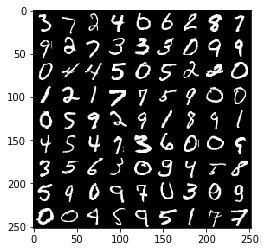

In [23]:
#normalize 안한 것
digit_size = 28
figure = np.zeros((9*digit_size,9*digit_size))
for i in range(9):
    for j in range(9):
        temp = img[i*10 + j]
        temp = np.array(temp)
        figure[i*digit_size:(i+1)*digit_size, j*digit_size : (j+1)*digit_size] = temp 
plt.imshow(figure, cmap = 'gray') 
plt.show() 

In [62]:
#normalize 안했을 때
print(img.max()) 
print(img.min()) 
#0부터 1까지! -> normalize안해줬는데도 왜? 

tensor(1.)
tensor(0.)


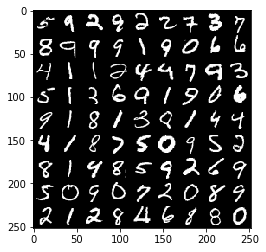

In [30]:
#normalize 한 것
digit_size = 28
figure = np.zeros((9*digit_size,9*digit_size))
for i in range(9):
    for j in range(9):
        temp = img[i*10 + j]
        temp = np.array(temp)
        figure[i*digit_size:(i+1)*digit_size, j*digit_size : (j+1)*digit_size] = temp 
plt.imshow(figure, cmap = 'gray') 
plt.show() 

In [10]:
#normalize 했을 때
print(img.max()) 
print(img.min()) 

tensor(1.)
tensor(-1.)


#### FC classification

In [9]:
class FC(nn.Module):
    
    def __init__(self):
    
        super(FC, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(128, 10),
            nn.Softmax()
        )
    
    def forward(self, x):
        layer1_out = self.layer1(x)
        layer2_out = self.layer2(layer1_out)
        score_out = self.layer3(layer2_out)
        
        return score_out

In [10]:
model = FC()
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters())
optimizer2 = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9) 

#### training

In [11]:
validation_minloss = 100  
for epoch in range(num_epochs):#num_epochs
    # training
    for data in dataloader1:#training data를 batch만큼 받아옴   
        #data 받아오기, resize하기 
        inputs, label = data  
        inputs = inputs.view(inputs.size(0), -1)   
        # forward  
        score_out = model(x = inputs)  
        loss = criterion(score_out,label) #nn.CrossEntropyLoss()는 label을 one-hot vector로 바꾸지 않아도 된다!
        # backward     
        optimizer2.zero_grad() # gradient를 처음에 0으로 만들어주는 것 -> gradient가 accumulating되기 때문에, 처음에 0이어야 함      
        loss.backward()   
        optimizer2.step() #가중치 업데이트?  
        
        #training accuracy 계산(batch마다)
        
    #한 epoch마다 loss 계산
    print("{}/{} epochs  training loss: {:.4f}".format((epoch+1),num_epochs, loss.data))
    
    #validation
    for data in dataloader2: #test data를 한번만 가져옴(batch = 10000) 이므로
        test_inputs, label = data
        test_inputs = test_inputs.view(test_inputs.size(0), -1)
        #forward 하고 loss 계산
        score_out = model(x = test_inputs)
        loss = criterion(score_out, label)
    print("{}/{} epochs validation loss: {:.4f}".format((epoch+1), num_epochs, loss.data))
    # 100 epochs 돌리는 중에서, best model 찾기!!!
    if validation_minloss >= loss:
        validation_minloss = loss  
        #모델저장
        best_model = model
 
        
## 끝까지 우선 돌린 다음에, validation loss 최소인거 찾아서 그것을 best model로 뽑아서 해야함(early stopping으로만 하면 안됨) 
torch.save(best_model, './sim_classification.pth')

C:\Users\lsh93\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


1/100 epochs  training loss: 1.9660
1/100 epochs validation loss: 1.9429
2/100 epochs  training loss: 1.6411
2/100 epochs validation loss: 1.6859
3/100 epochs  training loss: 1.6502
3/100 epochs validation loss: 1.6518
4/100 epochs  training loss: 1.6140
4/100 epochs validation loss: 1.6382
5/100 epochs  training loss: 1.6108
5/100 epochs validation loss: 1.6304
6/100 epochs  training loss: 1.6815
6/100 epochs validation loss: 1.6247
7/100 epochs  training loss: 1.5807
7/100 epochs validation loss: 1.6228
8/100 epochs  training loss: 1.6026
8/100 epochs validation loss: 1.6181
9/100 epochs  training loss: 1.5791
9/100 epochs validation loss: 1.6149
10/100 epochs  training loss: 1.6193
10/100 epochs validation loss: 1.6137
11/100 epochs  training loss: 1.6156
11/100 epochs validation loss: 1.6095
12/100 epochs  training loss: 1.5592
12/100 epochs validation loss: 1.5635
13/100 epochs  training loss: 1.5203
13/100 epochs validation loss: 1.5522
14/100 epochs  training loss: 1.5385
14/100

C:\Users\lsh93\Anaconda3\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FC. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
#one - hot vector로 바꾸는 방법   
a = np.array([1, 0, 3, 5]) #label  
b = np.zeros((4, 6)) #label_  
b[np.arange(4), a] = 1   
b 

array([[ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

In [12]:
print("validation minimum loss: {}".format(validation_minloss.data))

validation minimum loss: 1.4864521026611328


#### test
- test data를 이용해서 forward를 시키고, loss와 classification accuracy를 산출한다. 

In [13]:
from sklearn.metrics import accuracy_score 
#from sklearn.metrics import confusion_matrix

In [14]:
# forward propagation  
for i in range(1):
    for data in dataloader2: # test data한번에 받아오기
        test_inputs, label = data 
        test_inputs = test_inputs.view(test_inputs.size(0), -1)  
        score_out = model(test_inputs)  
        loss = criterion(score_out, label)  
    print("test loss: {:.4f}".format(loss.data))   
    
# classification accuracy
_, labeled_out = torch.max(score_out, 1)  
accuracy = accuracy_score(labeled_out.detach().numpy(), label.detach().numpy())  
print("test accuracy: {:.4f}".format(accuracy))  

test loss: 1.4876
test accuracy: 0.9755


C:\Users\lsh93\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
